## 定期預金の契約についてのデータセット

データの取得
- https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip<br>
bank.csv を使用

データの説明
- https://archive.ics.uci.edu/ml/datasets/bank+marketing

内容を確認
- "age";"job";"marital";"education";"default";"balance";"housing";"loan";"contact";"day";"month";"duration";"campaign";"pdays";"previous";"poutcome";"y"<br>
30;"unemployed";"married";"primary";"no";1787;"no";"no";"cellular";19;"oct";79;1;-1;0;"unknown";"no"
- "y" 定期預金を預けてくれたかどうか

<hr>

## クラスタリングによる顧客の分析

定期預金を契約してくれた顧客層を把握するために分析する。

変数としては以下を用いる：
- age: 年齢
- balance: 貯金残高
- campaign: 勧誘のコンタクト回数
- previous: campaign以前のコンタクト回数

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# matplotlib: 日本語フォントの設定（MacOS）
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 
                               'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']

bank = pd.read_csv('data/bank.csv', sep=';')
# 使用する列だけ取り出す
df = bank[['age', 'balance', 'campaign', 'previous']]
# 列ごとの欠損値の数
df.isna().sum()

age         0
balance     0
campaign    0
previous    0
dtype: int64

In [2]:
df.head(2)

,age,balance,campaign,previous
0,30,1787,1,0
1,33,4789,1,4


各列のデータは値が大きく異なるため、データの標準化を行う。
- 分布を標準偏差をもとに調整
- 平均値が0、標準偏差が1となるように変換

In [3]:
# データの標準化
sc = StandardScaler()
sc.fit(df)
X = pd.DataFrame(sc.transform(df), index=df.index, columns=df.columns)

# 出力の表記を設定
# - pd.options.display.float_format: 小数点以下の表示方法を指定
pd.options.display.float_format = '{:.2f}'.format

# 代表値を確認
X.describe()

,age,balance,campaign,previous
count,4521.00,4521.00,4521.00,4521.00
mean,-0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00
min,-2.10,-1.57,-0.58,-0.32
25%,-0.77,-0.45,-0.58,-0.32
50%,-0.21,-0.33,-0.26,-0.32
75%,0.74,0.02,0.07,-0.32
max,4.33,23.18,15.18,14.44


標準化により 平均 0, 標準偏差 1 にしたが、balance, campaign, previous の max の値が大きい。

- min, max の範囲がある程度揃っていないと、以下のヒートマップを描画時に、色が潰れてしまう。

### ヒートマップ

/Users/kazuya/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


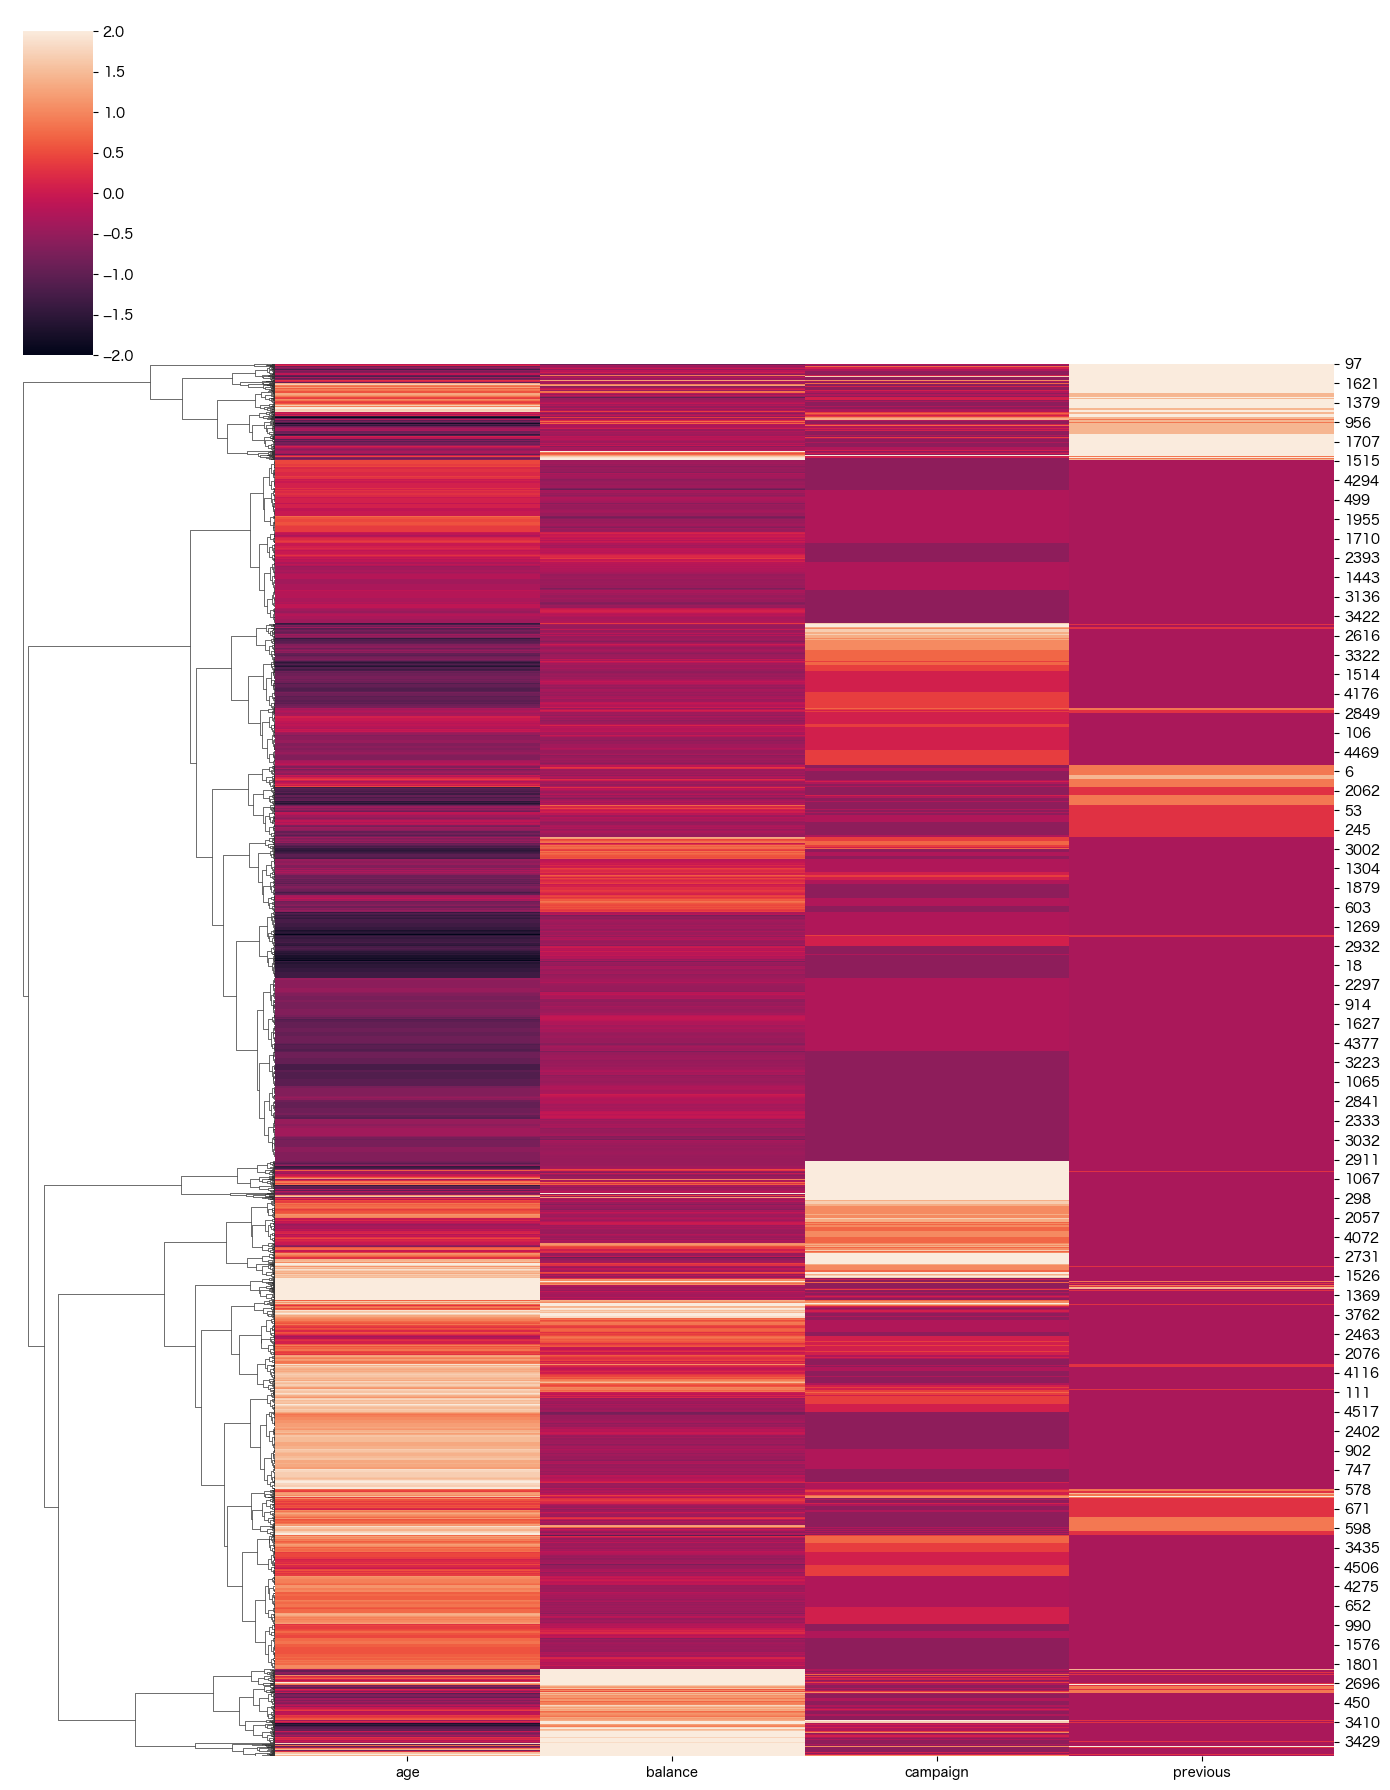

In [4]:
# ヒートマップ付きの樹形図を作成
# - vmin, vmax: 色との対応の範囲を制限
#   - balance, campaign, previous の最大値が大きく、色が潰れてしまう
#     vmin=-2, vmax=2, と範囲を制限することで、バランスよく色が描画される
#   - オプションを指定しない場合と比較
sns.clustermap(X, method='ward', metric='euclidean', vmin=-2, vmax=2,
               figsize=(14, 18), col_cluster=False)

### クラスタ数

枝が一番長いところのクラスタ数は 5

### クラスタ平均

In [5]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import cut_tree

# 階層的凝集クラスタリング
# - method='ward' Ward法
clusters = linkage(X.values, method='ward', metric='euclidean')

# cut_tree: 指定したクラスタ数でのラベル（クラスタ番号）を取得
labels = np.ndarray.flatten(cut_tree(clusters, 5))

# クラスタ番号を結合したDataFrameを作成
df_cluster = pd.concat([df, pd.DataFrame(labels, index=X.index, columns=['cluster'])], axis=1)

# クラスタごとの平均値
df_cluster.groupby('cluster').mean()

,age,balance,campaign,previous
cluster,,,,
0,34.43,599.51,2.11,0.17
1,39.88,1506.58,2.22,5.45
2,52.13,1204.53,2.92,0.19
3,39.40,9271.15,2.25,0.32
4,37.55,1098.17,16.05,0.01


### クラスタの特徴

クラスタ平均は数値、ヒートマップでは色が薄いと値が大きいことがわかる。

- age: 年齢が高めの層がクラスタを形成
- balance: 貯金残高が高い層がクラスタを形成
- campaign: 勧誘のコンタクト回数が多い層がクラスタを形成
- previous: これまでののコンタクト回数が多い層がクラスタを形成
- 上記にあてはまらない層がクラスタを形成

## クラスタ数の推定

- エルボー法
- シルエット分析

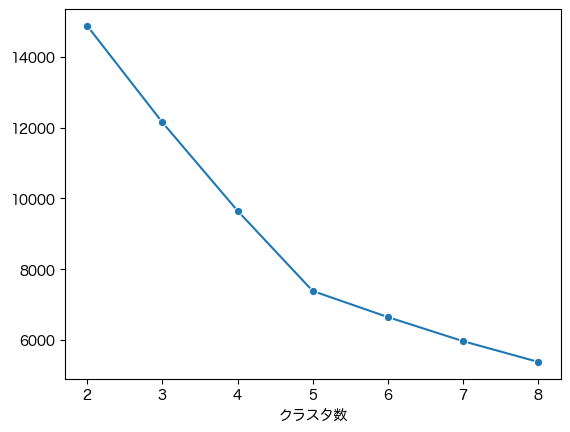

In [6]:
# エルボー法
# https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch11/ch11.py
distortions = []
x_range = range(2, 9)
for n in x_range:
    model = KMeans(n_clusters=n, random_state=0)
    model.fit(X)
    distortions.append(model.inertia_)

sns.lineplot(x=x_range, y=distortions, marker='o')
plt.xlabel('クラスタ数')
plt.show()

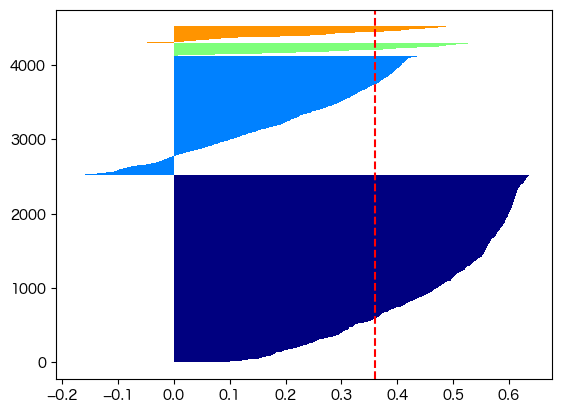

4 Clusters: Average silhouette width: 0.359


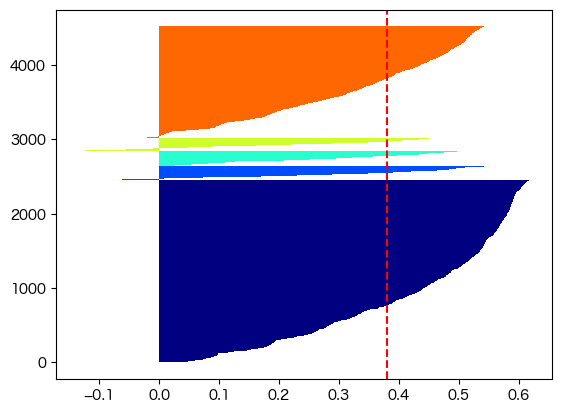

5 Clusters: Average silhouette width: 0.381


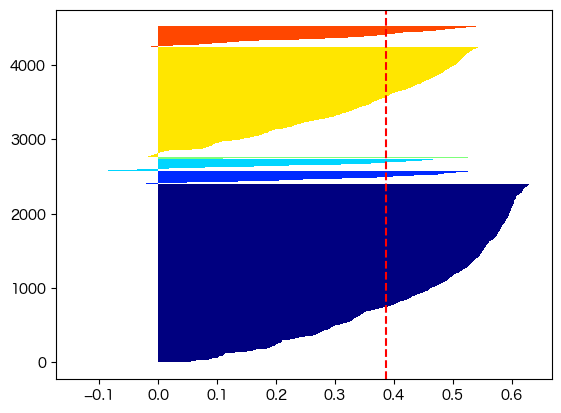

6 Clusters: Average silhouette width: 0.386


In [7]:
# シルエット分析
# https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch11/ch11.py
from sklearn.metrics import silhouette_samples
from matplotlib import cm

def silhouette(n):
    model = KMeans(n_clusters=n, random_state=0)
    model.fit(X)
    cluster_labels = set(model.labels_)
    n_clusters = len(cluster_labels)
    silhouette_vals = silhouette_samples(X, model.labels_, metric='euclidean')
    y_lower, y_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[model.labels_ == c]
        c_silhouette_vals.sort()
        y_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_lower, y_upper), c_silhouette_vals, height=1.0,
                 edgecolor='none', color=color)
        yticks.append((y_lower + y_upper) / 2.)
        y_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.show()
    print('{} Clusters: Average silhouette width: {:.3f}'.format(n, silhouette_avg))

for n in range(4, 7):
    silhouette(n)

### クラスタ数の推定結果

- エルボー法：5 で明確に折れ曲がっている
- シルエット分析：5, 6 の平均シルエット係数が大きい

ヒートマップの結果と合わせると、クラスタ数は5が適当と考えられる。

<hr>

## クラスタリング結果の解釈

クラスタ数は5とする。

- KMeans に ramdom_state=0 を渡しても、クラスタのラベル番号の付け方までは同じにならないようで、ここで表示する結果と全く同じにならない場合があります。

In [8]:
# クラスタ番号の列を追加
model = KMeans(n_clusters=5, random_state=0)
model.fit(X)

# KMeansで分割されたクラスタ番号を列データとして追加
# - ヒストグラム等でクラスタごとに描画、比較できるようにする
bank['cluster'] = model.labels_

# 確認
bank.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,cluster
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no,2


### クラスタ別の年齢層

クラスタごとに年齢層に違いがあるかを見てみる

<AxesSubplot:xlabel='age', ylabel='Count'>

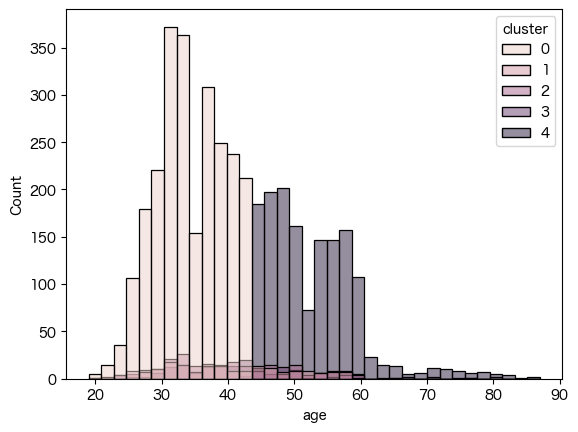

In [9]:
sns.histplot(data=bank, x='age', hue='cluster')

- 40台前半まで
- 40台後半以上

の2つの大きなクラスタが形成されている。

その他、3つのクラスタは小さく、ヒストグラムでは潰れてしまっている。

### クラスタ別の年齢層

カテゴリーごとの度数を集計するクロス集計を用いて、クラスタ別の年齢層を比較する。クラスタごとに、度数を比較することで、傾向の違いが見える（場合がある）。

In [10]:
# 年齢の区間
bins = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 100]
# 年齢を各区間に振り分け
# - right=False: 右側が開いた区間 [0, 20), ..., [65, 100)
age_freq = pd.cut(bank.age, bins, right=False)
# クラスタ番号を追加
df_age = pd.concat([bank.cluster, age_freq], axis=1)
# クラスタ番号と年齢別にクロス集計
df_age_cross = pd.crosstab(df_age.cluster, df_age.age)
# 確認
df_age_cross

age,"[0, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 100)"
cluster,,,,,,,,,,,
0,3,52,372,869,711,450,0,0,0,0,0
1,1,4,18,39,33,22,25,22,15,0,1
2,0,3,18,53,42,34,24,24,9,1,4
3,0,4,7,29,32,40,21,16,19,3,6
4,0,0,0,0,0,92,495,381,368,81,78


クロス集計からは、3つの小さいクラスタは、30~45歳が多い傾向があるように見える。

クラスタごとの度数の割合をヒートマップで可視化することで、クラスタごとの傾向を並べて比較できる。

<AxesSubplot:xlabel='age', ylabel='cluster'>

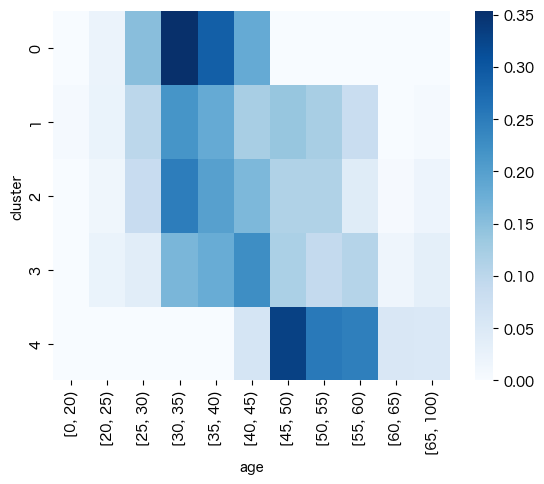

In [11]:
sns.heatmap(df_age_cross.apply(lambda x: x/x.sum(), axis=1), cmap='Blues')

### クラスタ別の職業

クロス集計を用いて、クラスタ別の職業を比較する。

In [ ]:
# クラスタ番号を追加
df_job = pd.concat([bank.cluster, bank.job], axis=1)
# クラスタ番号と職業別にクロス集計
df_job_cross = pd.crosstab(df_job.cluster, df_job.job)
# 確認
df_job_cross

ヒートマップで可視化。

In [ ]:
sns.heatmap(df_job_cross.apply(lambda x: x/x.sum(), axis=1), cmap='Blues')

どのようなクラスタがあるか：

- management（管理者）が多く、blue-collar が少ない
- 退職者が多め（その他の職種も混在）…年齢層が高い？
- services（対人サービス？）, self-employed（個人事業主）がやや多く、blue-collar, management も多め
- technician（技術職員）が多いと、admin（事務職員）が多い